### Experiment1_Plotting distances and angles
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Studying the feature vectors in the feature space

In [1]:
import os
from six.moves import xrange  # pylint: disable=redefined-builtin
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K

# Custom scripts
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [2]:
height=112 
width=112 
channel=3
crop_size=112

cluster_length=16
feature_size=4608 #8192   #16384  #487
nb_classes=2
saved_path='/nobackup/leopauly/logdirk80_1_rand_frames'

batch_size=32
memory_batch_size_train=266
memory_batch_size_test=170
next_batch_start=0
sample_batch_size=10

In [3]:
## Defining placeholders in tf for images and targets
x_image = tf.placeholder(tf.float32, [None, 16,height,width,channel],name='x') 
y_true = tf.placeholder(tf.float32, [None, nb_classes],name='y_true')
y_true_cls = tf.placeholder(tf.int64, [None],name='y_true_cls')

model_keras = md.C3D_ucf101_training_model_tf(summary=True)
out=model_keras(x_image)
y_pred = tf.nn.softmax(out)
y_pred_cls = tf.argmax(out, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('Miscellenious items finished..!!',flush=True)

/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_C_Basics/modelling.py:281: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", name="conv1", input_shape=(16, 112, ..., padding="same")`
  input_shape=input_shape))
/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_C_Basics/modelling.py:283: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid")`
  border_mode='valid', name='pool1'))
/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_C_Basics/modelling.py:286: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", padding="same")`
  border_mode='same', name='conv2'))
/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_C_Basics/modelling.py:288: UserWarning: Update your `MaxPooling3D` call to the Ke

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0         
__________

In [4]:
def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    cos_val=dotproduct(v1, v2) / (length(v1) * length(v2))
    cos_val=float(cos_val)
    cos_val=clean_cos(cos_val)
    angle_in_rad=math.acos(cos_val)
    #print(angle_in_rad)
    return angle_in_rad

def clean_cos(cos_val):
    return min(1,max(cos_val,-1))

In [5]:
def get_frames_data(filename, num_frames_per_clip=16):
  ''' Given a directory containing extracted frames, return a video clip of
  (num_frames_per_clip) consecutive frames as a list of np arrays '''
  ret_arr = []
  s_index = 0
  for parent, dirnames, filenames in os.walk(filename):
    if(len(filenames)<num_frames_per_clip):
      return [], s_index
    filenames = sorted(filenames)
    s_index = random.randint(0, len(filenames) - num_frames_per_clip)
    for i in range(s_index, s_index + num_frames_per_clip):
      image_name = str(filename) + '/' + str(filenames[i])
      img = Image.open(image_name)
      img_data = np.array(img)
      #lsp.view_image(img_data)
      ret_arr.append(img_data)
  ret_arr=np.array(ret_arr)
  #ret_arr=ret_arr/255
  print('ret_arr',ret_arr.shape)
  return ret_arr

In [6]:
## Extraction of features - baseline
def extract_baseline_video_features(vid):
    vid_=vid.reshape(-1,cluster_length,height,width,channel)
    f_v = sess.graph.get_tensor_by_name('flatten_1/Reshape:0')
    f_v_val=sess.run([f_v], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })
    features=np.reshape(f_v_val,(-1))
    return features

In [7]:
def dist_angle_calc(directory1,directory2):
    baseline_dist=[]
    baseline_angle=[]
    activity_dist=[]
    activitynet_angle=[]
    
    subfolders1=os.listdir(directory1)
    subfolders1=sorted(subfolders1)
    subfolders2=os.listdir(directory2)
    subfolders2=sorted(subfolders2)
    
    for subfolder1_ in subfolders1:
        data1=get_frames_data(directory1+'/'+subfolder1_)
        
        for subfolder2_ in subfolders2:
            data2=get_frames_data(directory2+'/'+subfolder2_)
            
            dist_base_=np.linalg.norm(extract_baseline_video_features(data1)-extract_baseline_video_features(data2))
            
            baseline_dist.append(dist_base_)
            
            angle_base_=angle(extract_baseline_video_features(data1),extract_baseline_video_features(data2))
            
            baseline_angle.append(angle_base_)
    
    return baseline_dist,baseline_angle

In [8]:
#### Start the session with logging placement.
init_op = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
sess.run(init_op)

### Restore model weights from previously saved model
#saver = tf.train.import_meta_graph(os.path.join(saved_path,'activity_model_1.ckpt-43.meta'))
saver = tf.train.Saver()
saver.restore(sess, os.path.join(saved_path,'activity_model.ckpt-104'))
print("Model restored from file: %s" % saved_path,flush=True)

INFO:tensorflow:Restoring parameters from /nobackup/leopauly/logdirk80_1_rand_frames/activity_model.ckpt-104
Model restored from file: /nobackup/leopauly/logdirk80_1_rand_frames


In [9]:
## Getting feature space distances for values for similar activity videos
baseline_plot_sim=[]
baseline_plot_angle_sim=[]
activitynet_plot_sim=[]


baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/hit','/nobackup/leopauly/leeds_reordered/hit')
#print(baseline_dist_)
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/push','/nobackup/leopauly/leeds_reordered/push')
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/reach','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/pour')
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])


ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16,

In [10]:
baseline_plot_sim=np.array(baseline_plot_sim)
baseline_plot_sim=baseline_plot_sim.reshape(100)
print(baseline_plot_sim)
print(baseline_plot_sim.shape)

[ 102.81534576  223.19378662  146.00016785  287.58764648  204.99815369
  234.6965332   293.96548462  251.76152039  269.14862061  186.95484924
  306.70016479  211.17274475  282.82510376  229.67752075  240.3608551
  310.94625854  284.50598145  261.28213501   15.885602    197.72003174
  285.70022583  262.61709595  255.08804321  192.63432312  130.3215332
  123.59648895  116.77351379  170.11637878  220.96539307  235.17875671
  180.82418823  162.08448792  225.56373596  252.52445984  236.90864563
  186.43234253  158.94067383  162.4556427   192.35527039  242.91706848
  220.96539307  243.97013855  202.72953796  268.01870728  117.61260223
  209.32305908  227.49946594  177.82447815  289.35919189  161.71102905
   43.54020691   76.24254608  203.3999939   150.78190613  154.08114624
  164.37033081   59.4676857   147.91912842  178.98979187  268.37652588
  134.53474426  110.47990417   34.45733261  261.646698    297.16546631
  319.95986938  300.13430786  178.73652649   57.76486969  214.15504456
  265.48

In [11]:
baseline_plot_angle_sim=np.array(baseline_plot_angle_sim)
baseline_plot_angle_sim=baseline_plot_angle_sim.reshape(100)
print(baseline_plot_angle_sim)
print(baseline_plot_angle_sim.shape)

[ 0.20614954  0.46467067  0.2919152   0.60294629  0.41920159  0.48934962
  0.605104    0.52431688  0.59030651  0.41229071  0.61824345  0.43483247
  0.56217636  0.47186022  0.49968069  0.65270958  0.6223626   0.54750667
  0.03398137  0.43313804  0.605695    0.58622479  0.54181189  0.41145416
  0.28066008  0.26351027  0.24786767  0.36941862  0.45674847  0.48790222
  0.38034976  0.33977484  0.47640623  0.52084534  0.49742926  0.40382898
  0.34127861  0.35685913  0.39033633  0.52109097  0.45674847  0.50294508
  0.41865778  0.53627989  0.23808292  0.44087128  0.47718554  0.37357705
  0.58443634  0.33525044  0.08471153  0.14867702  0.40940105  0.2995847
  0.30575372  0.34084931  0.12309281  0.30309997  0.37629536  0.56449663
  0.2727221   0.22761648  0.06862337  0.53990928  0.61982529  0.64592672
  0.61729461  0.36664821  0.1166294   0.44431237  0.55065398  0.59455307
  0.47976756  0.41999705  0.08417211  0.28555915  0.85471008  0.50285513
  0.56314027  0.8685567   0.78369151  0.73388743  0.

In [12]:
## Getting feature space distances for values for dissimilar activity videos
baseline_plot_dis=[]
baseline_plot_angle_dis=[]
activitynet_plot_dis=[]


baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/hit','/nobackup/leopauly/leeds_reordered/push')
#print(baseline_dist_)
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/hit','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/push','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/hit')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/push')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16, 112, 112, 3)
ret_arr (16,

In [13]:
baseline_plot_dis=np.array(baseline_plot_dis)
baseline_plot_dis=baseline_plot_dis.reshape(150)
print(baseline_plot_dis)
print(baseline_plot_dis.shape)

[ 302.47769165  297.29354858  272.46447754  320.97842407  327.64733887
  348.37799072  383.05477905  346.59408569  351.25979614  368.06768799
  241.42195129  283.55056763  290.17739868  173.06886292  284.17132568
  224.84011841  234.59165955  215.81542969  298.30438232  263.0223999
  200.55862427  206.56575012  254.65512085  252.87445068  257.9821167
  361.90759277  328.40512085  320.11474609  343.33795166  371.22109985
  329.07830811  331.66345215  282.66003418  319.0708313   282.61437988
  306.55834961  299.32147217  317.1194458   288.2661438   305.04446411
  197.07331848  252.28062439  203.32791138  271.66940308  248.12721252
  297.08709717  323.21917725  278.52456665  296.37390137  301.574646
  232.54525757  220.18266296  212.18055725  241.12121582  190.33155823
  282.09494019  191.34365845  260.19760132  210.45849609  239.6574707
  301.89038086  301.51968384  266.35137939  300.75604248  231.71432495
  323.5802002   358.94369507  289.08984375  296.39028931  278.79763794
  319.92150

In [14]:
baseline_plot_angle_dis=np.array(baseline_plot_angle_dis)
baseline_plot_angle_dis=baseline_plot_angle_dis.reshape(150)
print(baseline_plot_angle_dis)
print(baseline_plot_angle_dis.shape)

[ 0.63373289  0.61852523  0.57325176  0.64944298  0.68012255  0.74228039
  0.8034653   0.74879469  0.7285454   0.76379518  0.50604781  0.59017558
  0.60851272  0.3524274   0.59149093  0.4650659   0.48605108  0.45218357
  0.5981558   0.54378137  0.43849278  0.44637252  0.56134767  0.5245408
  0.55464031  0.73887623  0.67819947  0.65668133  0.70903004  0.7676365
  0.67913448  0.69169475  0.59166159  0.66751509  0.60406724  0.63394124
  0.62616538  0.66358928  0.5979124   0.64308407  0.41173874  0.53538292
  0.42639676  0.55995434  0.52114792  0.62976451  0.68152367  0.60170213
  0.63264747  0.6391893   0.47682538  0.46094001  0.45071511  0.50117544
  0.40277321  0.57585739  0.40650123  0.54888604  0.44209851  0.51154677
  0.62872233  0.63677922  0.56503082  0.63069708  0.49743626  0.66587595
  0.73858022  0.60273839  0.61633229  0.58462632  0.66658861  0.7374683
  0.65374085  0.6721549   0.66152412  0.72018525  0.8016081   0.72894083
  0.80019133  0.80670245  0.80214574  0.7969068   0.79

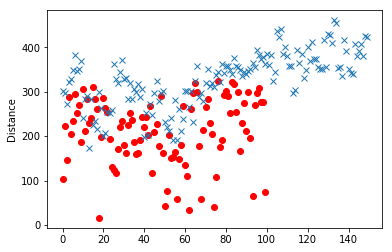

In [15]:
## Plotting
plt.plot(baseline_plot_sim,'ro')
plt.plot(baseline_plot_dis,'x')
plt.ylabel('Distance')
plt.show()

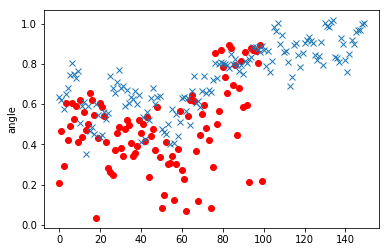

In [16]:
## Plotting
plt.plot(baseline_plot_angle_sim,'ro')
plt.plot(baseline_plot_angle_dis,'x')
plt.ylabel('angle')
plt.show()